In [1]:
import numpy as np
import pandas as pd

from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

import warnings                                  
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()

data = diabetes.data
targets = diabetes.target

In [3]:
data[:3]

array([[ 0.03807591,  0.05068012,  0.06169621,  0.02187235, -0.0442235 ,
        -0.03482076, -0.04340085, -0.00259226,  0.01990842, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, -0.02632783, -0.00844872,
        -0.01916334,  0.07441156, -0.03949338, -0.06832974, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, -0.00567061, -0.04559945,
        -0.03419447, -0.03235593, -0.00259226,  0.00286377, -0.02593034]])

In [4]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

random_state=42
n_iter=50

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, 
                                                                      test_size=0.20, shuffle=True,
                                                                     ) 
num_folds=2
kf = KFold(n_splits=num_folds )

In [5]:
print('train_data : ',train_data.shape)
print('test_data : ',test_data.shape)

print('train_targets : ',train_targets.shape)
print('test_targets : ',test_targets.shape)


train_data :  (353, 10)
test_data :  (89, 10)
train_targets :  (353,)
test_targets :  (89,)


## 모델 생성 

In [6]:
model = LGBMRegressor(random_state= random_state)

score = -cross_val_score(model, train_data, train_targets, cv = kf, scoring="neg_mean_squared_error", n_jobs=-1).mean()
print(score)

4025.6947510270847


#### 파라미터 종류 

* base_estimator: 기본 모형
* n_estimators: 모형 갯수. 디폴트 10
* bootstrap: 데이터의 중복 사용 여부. 디폴트 True
* max_samples: 데이터 샘플 중 선택할 샘플의 수 혹은 비율. 디폴트 1.0
* bootstrap_features: 특징 차원의 중복 사용 여부. 디폴트 False
* max_features: 다차원 독립 변수 중 선택할 차원의 수 혹은 비율 1.0

## GridSearch

하이퍼 파라미터 최적화를 수행하는 전통적인 방법은 그리드 검색 또는 매개 변수 스윕으로, 학습 알고리즘의 하이퍼 파라미터 공간에서 수동으로 지정된 하위 집합을 통해 전체적으로 검색하는 것입니다.  

*  간단한 방법은 sklearn.model_selection에 포함 된 GridSearchCV입니다.이 접근 방식은 사용 가능한 모든 매개 변수의 조합을 1 x 1로 시도하고 최상의 교차 검증 결과를 가진 것을 선택합니다.

#### 몇가지 단점이 존재
* 매우 느립니다. 모든 매개 변수의 모든 조합을 시도하고 많은 시간이 걸립니다. 변량 할 추가 매개 변수는 완료해야하는 반복 횟수를 곱합니다. 
* 이산 값으로 만 작동 할 수 있습니다. 
* 적절한 시간에 검색을 완료하려면 approximate localization of the optimum를 알고 / 추측해야합니다.

예시 우리의 경우 그리드 검색을 수행하는 데 걸리는 시간을 추정 해 보겠습니다.
그리드가 'n_estimators'(100 ~ 2000)의 가능한 값 20 개,
'max_depth'의 19 개 값 (2 ~ 20),
'learning_rate'(10e-4 ~ 0.1)의 5 개 값으로 구성되기를 원한다고 가정 해 보겠습니다.
즉, cross_val_score 20 * 19 * 5 = 1900 번 계산해야합니다. 1 번 계산에 0.5 ~ 1.0 초가 걸리면 그리드 검색은 15 ~ 30 분 동안 지속됩니다. 

In [7]:
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import GridSearchCV

param_grid={'max_depth':  np.linspace(5,12,8,dtype = int),
            'n_estimators': np.linspace(800,1200,5, dtype = int),
            'learning_rate': np.logspace(-3, -1, 3),            
            'random_state': [random_state]}

gs=GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=kf, verbose=False)

gs.fit(train_data, train_targets)
gs_test_score=mean_squared_error(test_targets, gs.predict(test_data))


print('===========================')
print("Best MSE = {:.3f} , when params {}".format(-gs.best_score_, gs.best_params_))
print('===========================')

Best MSE = 3864.779 , when params {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800, 'random_state': 42}


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

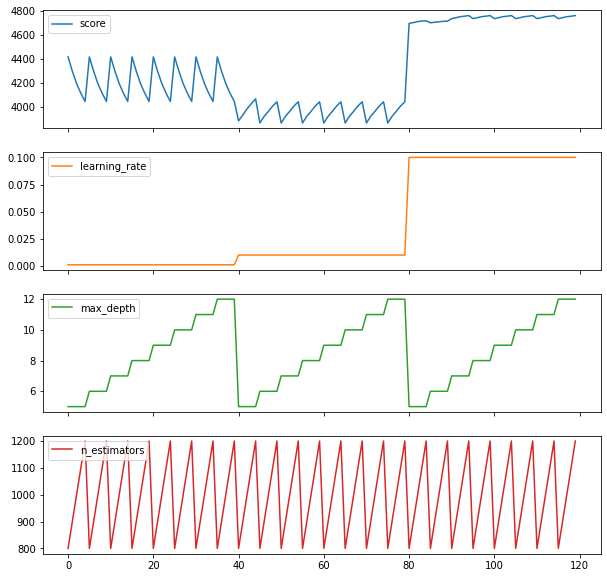

In [8]:
gs_results_df=pd.DataFrame(np.transpose([-gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_learning_rate'].data,
                                         gs.cv_results_['param_max_depth'].data,
                                         gs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

max_depth는 점수에 크게 영향을주지 않는 가장 덜 중요한 매개 변수임을 알 수 있습니다. 그러나 우리는 max_depth의 8 가지 다른 값을 검색하고 다른 매개 변수에 대한 고정 값 검색을 사용합니다. 시간과 자원의 낭비입니다.

## Random GridSearch

* 장점
* 의미없는 매개 변수에 시간을 소비하지 앉음. 모든 단계에서 무작위 검색은 모든 매개 변수를 변경합니다.
* 평균적으로 그리드 검색보다 훨씬 빠르게 ~ 최적의 매개 변수를 찾습니다.
* 연속 매개 변수를 최적화 할 때 그리드에 의해 제한되지 않습니다.  


* 단점 
* 그리드에서 글로벌 최적 매개 변수를 찾지 못할 수 있습니다.
* 모든 단계는 독립적입니다. 모든 특정 단계에서 지금까지 수집 된 결과에 대한 정보를 사용하지 않습니다.

논문 : https://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid_rand={'learning_rate': np.logspace(-5, 0, 100),
                 'max_depth':  randint(2,20),
                 'n_estimators': randint(100,2000),
                 'random_state': [random_state]}

rs=RandomizedSearchCV(model, param_grid_rand, n_iter = n_iter, scoring='neg_mean_squared_error',
                n_jobs=-1, cv=kf, verbose=False, random_state=random_state)

rs.fit(train_data, train_targets)

rs_test_score=mean_squared_error(test_targets, rs.predict(test_data))

print('===========================')
print("Best MSE = {:.3f} , when params {}".format(-rs.best_score_, rs.best_params_))
print('===========================')

Best MSE = 3609.466 , when params {'learning_rate': 0.01519911082952933, 'max_depth': 2, 'n_estimators': 559, 'random_state': 42}


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

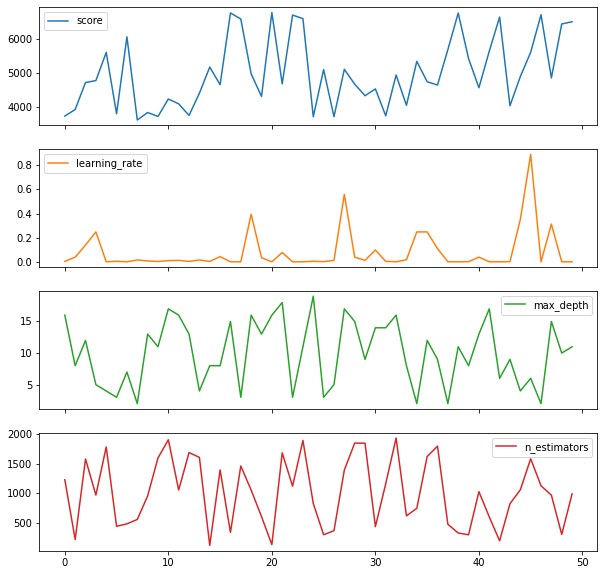

In [10]:
rs_results_df=pd.DataFrame(np.transpose([-rs.cv_results_['mean_test_score'],
                                         rs.cv_results_['param_learning_rate'].data,
                                         rs.cv_results_['param_max_depth'].data,
                                         rs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

## HyperBand 

#### Successive Halving Algorithm ,SHA 
제한된 시간에서 최소의 loss를 갖는 모델의 하이퍼 파라미터 구성을 찾는 것이 목표이다. 
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FHMNyz%2Fbtq4WMdHZ6f%2FKYujBYqL3jRqk8vc8XgsE0%2Fimg.png" width="300" height="300"/>  

* 총탐색에 소요되는 budget 설정. (B) (*budget(epoch, data 등 학습에 투입되는 자원))
* n개의 하이퍼 파라미터 설정을 랜덤 하게 뽑는다. (Sk)
* S0의 모델들에 동일한 budget을 할당. (rk)
* 학습 및 중간 loss 추출.
* 중간 loss를 기준으로, 성능이 좋지 않은 하이퍼 파라미터 설정을 반만큼 버림. (Sk+1)
* 하나의 하이퍼 파라미터 설정이 남을 때까지 2, 3, 4, 5를 반복.

Successive Halving Algorithm(SHA)의 단점

* 알고리즘 자체의 hyperparameter(input) : B와 n (정확히는 B/n)에 따라서 exploration과 exploitation의 비율이 정해진다.따라서 알고리즘 성능을 위해 B와 n이라는 hyperparameter 설정이 굉장히 중요해진다.


---------

Hyperband는 SHA의 단점에서 언급된 B와 n의 단점을 보완한 알고리즘이다. 

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdvuOwS%2Fbtq4W1hp52C%2FaESKlEGztKEC6FKJwMaEy1%2Fimg.png" width="500" height="300"/>  


1. 하나의 하이퍼 파라미터 설정에 최대로 할당할 budget 설정 (R) (*budget(epoch, data 등 학습에 투입되는 자원))
2. SHA의 매 step마다 줄어드는 설정 개수(혹은 늘어나는 budget의 비율) 설정. (etha = ŋ ) (SHA에서는 2)
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fdxb91g%2Fbtq4Xbxt3jb%2FrULW4RF1aO7DncH8rqmhf0%2Fimg.png" width="300" height="300"/>  

3. R과 etha에 따라서 SHA를 반복할 개수 (etha(ŋ) defailt = 3) (1 SHA = 1 bracket으로) 및 각 SHA의 처음 step에서 초기화하는 설정의 개수와 할당되는 budget이 계산됨 (위의 공식에서 Smax가 bracket)

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbGSPDA%2Fbtq4YskWCBQ%2F6V5VPOj0mkHSAr4CtseWU1%2Fimg.png" width="300" height="300"/>  

4. R을 통해서 SHA에 들어갈 B,n 을 위의 공식을 통해 n,r 로 정해줌
5. 각 bracket의 SHA 모두 실행




## Bayesian optimization 

Random 또는 Grid Search와 달리 베이지안 접근 방식은 목표 함수의 점수 확률에 하이퍼 파라미터를 매핑하는 확률 모델을 형성하는데 사용하는 과거 평가 결과를 추적합니다. 
<img src="https://github.com/hyeonsangjeon/Hyperparameters-Optimization/raw/master/pic/bayesopt2.png?raw=true" width="300" height="300"/>  

논문에서 이 모델은 목적 함수에 대한 "surrogate"라고하며 p (y | x)로 표시됩니다. surrogate 함수는 목적 함수보다 최적화하기 훨씬 쉬우 며 베이지안 방법은 대리 함수에서 가장 잘 수행되는 하이퍼 파라미터를 선택하여 실제 목적 함수를 평가할 다음 하이퍼 파라미터 세트를 찾는 방식으로 작동합니다.

논문 : https://arxiv.org/pdf/1012.2599.pdf

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


search_space={'learning_rate': np.logspace(-5, 0, 100),
                 "max_depth": Integer(2, 20), 
                 'n_estimators': Integer(100,2000),
                 'random_state': [random_state]}
                 

def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True
    
bayes_search = BayesSearchCV(model, search_space, n_iter=n_iter, # specify how many iterations
                                    scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
bayes_search.fit(train_data, train_targets, callback=on_step) # callback=on_step will print score after each iteration

bayes_test_score=mean_squared_error(test_targets, bayes_search.predict(test_data))

print('===========================')
print("Best MSE = {:.3f} , when params {}".format(-bayes_search.best_score_, bayes_search.best_params_))
print('===========================')

In [ ]:
bayes_results_df=pd.DataFrame(np.transpose([
                                         -np.array(bayes_search.cv_results_['mean_test_score']),
                                         np.array(bayes_search.cv_results_['param_learning_rate']).data,
                                         np.array(bayes_search.cv_results_['param_max_depth']).data,
                                         np.array(bayes_search.cv_results_['param_n_estimators']).data
                                        ]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])



bayes_results_df.plot(subplots=True,figsize=(10, 10))

## Hyperopt 

HyperOpt는 베이지안 최적화의 접근 방식을 취합니다. 베이시안 최적화는 objective function(목적 함수)를 최대/최소로 하는 최적해를 찾는 기법입니다. 목적함수와 하이퍼파라미터의 Pair를 대상으로 Surrogate Model을 만들어 평가하면서 순차적으로 업데이트 하면서 최적의 조합을 찾아 냅니다.

여기서 Acquisition function의 개념이 추가로 나오는데 Surrogate Model은 목적 함수에 대한 확률적인 추정을 하며, Acquisition function은 Surrogate Model이 추정한 확률적 추정 결과를 바탕으로 다음 후보를 선정하는 함수입니다.


* fmin : 최소화 메인 목적 함수
* tpe and anneal : optimization 접근방식
* hp : 다양한 변수들의 분포 포함
* Trials : logging에 사용

In [23]:
from hyperopt import fmin, tpe, hp, anneal, Trials

def gb_mse_cv(params, random_state=random_state, cv=kf, X=train_data, y=train_targets):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate']}
    
    # we use this params to create a new LGBM Regressor
    model = LGBMRegressor(random_state=random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()

    return score

hyperop.fmin의 인터페이스는 Grid 또는 Randomized search와 다릅니다. 먼저, 최소화 할 함수를 정의


----

TPE는 Hyperopt의 기본 알고리즘입니다. 최적화를 위해 베이지안 접근 방식을 사용합니다. 모든 단계에서 함수의 확률 모델을 구축하고 다음 단계에서 가장 유망한 매개 변수를 선택하려고합니다. 일반적으로 이러한 유형의 알고리즘은 다음과 같이 작동합니다.

1. 임의의 initial point 생성 
2. 계산
3. trials 로깅 이력을 사용해서, 조건부 확률모델 를 생성
4. $ P (F | x) $에 따라 $ {F (x_i)} $가 더 나아질 가능성이 가장 높은 $ {x_i} $를 선택합니다.
5. $ {F (x_i)} $의 real values를 계산합니다.
6. 중지 기준 중 하나가 충족 될 때까지 3-5 단계를 반복합니다 (예 : i> max_eval).

In [28]:
# possible values of parameters


space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials, # logging
        #  rstate=np.random.Generator(42) # fixing random state for the reproducibility
         )

# computing the score on the test set
model = LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])
model.fit(train_data,train_targets)
tpe_test_score=mean_squared_error(test_targets, model.predict(test_data))

print("Best MSE {:.3f} params {}".format( gb_mse_cv(best), best))

100%|██████████| 50/50 [00:07<00:00,  6.71trial/s, best loss: 3624.487716535363] 
Best MSE 3624.488 params {'learning_rate': 0.017997321309752852, 'max_depth': 2.0, 'n_estimators': 133.0}


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

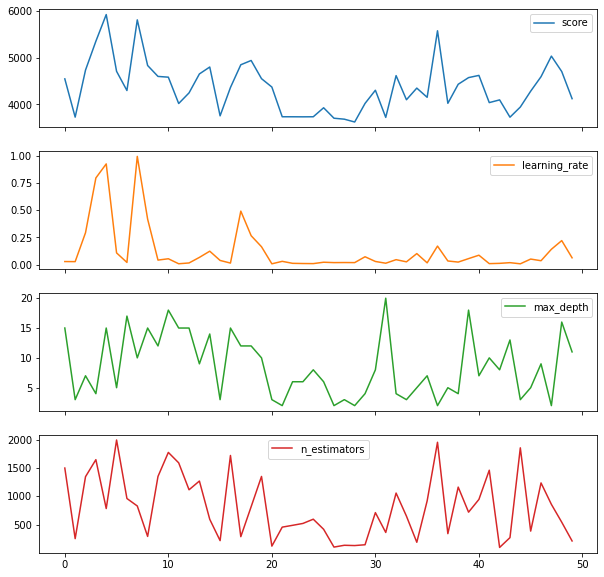

In [29]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
tpe_results_df.plot(subplots=True,figsize=(10, 10))

Text(0, 0.5, 'best_cumulative_score')

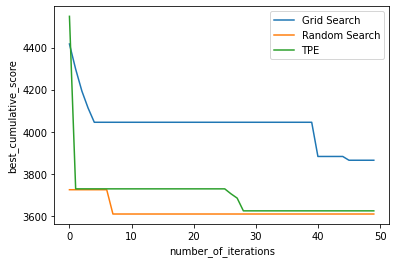

In [30]:
scores_df=pd.DataFrame(index=range(n_iter))
scores_df['Grid Search']=gs_results_df['score'].cummin()
scores_df['Random Search']=rs_results_df['score'].cummin()
#scores_df['Hyperband']=hb_results_df['score'].cummin()
# scores_df['Bayesian optimization ']=bayes_results_df['score'].cummin()
scores_df['TPE']=tpe_results_df['score'].cummin()


ax = scores_df.plot()

ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")

In [31]:
print('Test MSE scored:')
print("Grid Search : {:.3f}".format(gs_test_score))
print("Random Search :  {:.3f}".format(rs_test_score))
#print("Hyperband : {:.3f}".format(hb_test_score))
# print("Bayesian optimization : {:.3f}".format(bayes_test_score))
print("TPE : {:.3f}".format(tpe_test_score))

Test MSE scored:
Grid Search : 2847.573
Random Search :  2475.648
TPE : 2517.857
